# Data Augmentation

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import numpy as np
import glob as gb
from PIL import Image

## 1. Estudiar la descompensación

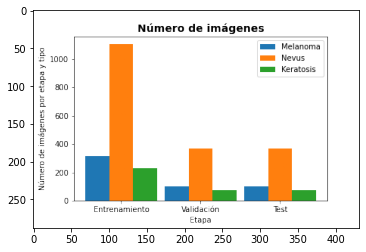

In [2]:
img = mpimg.imread('/Users/inma/Desktop/tfg/codigo/resultados/09-grafica_barras_nuevo_imagenes_etapa_tipo.png')
imgplot = plt.imshow(img)
plt.show()

Los datos están claramente descompensados, veamos los números extactos:

In [3]:
datos = pd.read_csv("resultados/06-tabla_nuevo_reparto_datos.csv")
datos

,Unnamed: 0,Melanoma,Nevus,Keratosis,Total Etapa
0,Entrenamiento,313,1107,232,1652
1,Validación,104,368,77,549
2,Test,104,368,77,549
3,Total Tipo,521,1843,386,2750


Los datos que vamos a aumentar son los de entrenamiento, así que tengamos esto en cuenta:
- 313 melanomas
- 1107 nevus
- 232 keratosis

Vamos a intentar corregir esta distribución = aumentar las imágenes de **melanoma** y de **keratosis** al doble.

## 2. Función de DataAugmentation

Esta función altera el tamaño de la imagen, el brillo, el contraste, la orientación, la saturación y recorta la imagen.

In [4]:
def augmentation(image):
    
    rng = tf.random.Generator.from_seed(random.randint(0,1000), alg='philox')
    seed = rng.make_seeds(2)[0]
    
    image_tuned = image.resize((224,224))
    image_tuned = tf.image.stateless_random_brightness(image_tuned, max_delta=0.1, seed=seed)
    image_tuned = tf.image.stateless_random_contrast(image_tuned, lower=0.7, upper=0.9, seed=seed)
    image_tuned = tf.image.stateless_random_crop(image_tuned, size=[200, 200, 3], seed=seed)
    image_tuned = tf.image.stateless_random_flip_left_right(image_tuned, seed=seed)
    image_tuned = tf.image.stateless_random_flip_up_down(image_tuned, seed=seed)
    image_tuned = tf.image.stateless_random_saturation(image_tuned, lower=0.8, upper=1, seed=seed)
    
    return image_tuned

Veamos si funciona con una imagen de ejemplo:

In [5]:
imagen = tf.keras.preprocessing.image.load_img("/Users/inma/Desktop/tfg/originales/train/melanoma/ISIC_0000552.jpg")
#imagen = imagen.resize((256,256))

In [6]:
imagen_aumentada = augmentation(imagen)

2022-05-11 09:51:39.161600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
print(type(imagen))
print(type(imagen_aumentada))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


Una función para visualizar el cambio en la imagen:

In [8]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

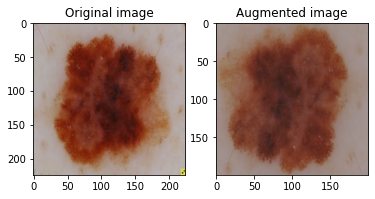

In [9]:
visualize(imagen.resize((224,224)), imagen_aumentada)

## 3. Hacer el aumento
Primero guardos los paths de las imagenes que voy a aumentar:

In [10]:
imgs_melanoma_paths = gb.glob("/Users/inma/Desktop/tfg/originales/train/melanoma/*.jpg")
imgs_keratosis_paths = gb.glob("/Users/inma/Desktop/tfg/originales/train/seborrheic_keratosis/*.jpg")

In [11]:
print(imgs_melanoma_paths[1:3])
print(imgs_keratosis_paths[1:3])

['/Users/inma/Desktop/tfg/originales/train/melanoma/ISIC_0012435.jpg', '/Users/inma/Desktop/tfg/originales/train/melanoma/ISIC_0014044.jpg']
['/Users/inma/Desktop/tfg/originales/train/seborrheic_keratosis/ISIC_0013065.jpg', '/Users/inma/Desktop/tfg/originales/train/seborrheic_keratosis/ISIC_0013918.jpg']


Aumentamos los paths, ya que necesitamos mas del doble de imágenes de cada tipo (tendré que aumentar cada imagen varias veces): 

In [49]:
def aumenta_paths(paths, num_images):
    max_images = 1000 
    k = round(1000 / num_images) + 1
    paths_aumentados = []
    for i in range(k):
        for path in paths:
            paths_aumentados.append(path)
            num_images += 1
            if num_images >= max_images:
                break     
    return paths_aumentados

In [35]:
mel_paths_aum = aumenta_paths(imgs_melanoma_paths, 313)
ker_paths_aum = aumenta_paths(imgs_keratosis_paths, 232)

In [36]:
print(len(mel_paths_aum))
print(len(ker_paths_aum))

688
769


In [48]:
a = 0
a +=1
a

1

Vamos a crear 688 imágenes de melanoma nuevas y 769 imágenes de kerastosis.

Declaro los path de los directorios de destino:

In [12]:
melanoma_path = "/Users/inma/Desktop/tfg/datos_aumentados/train/melanoma/"
keratosis_path = "/Users/inma/Desktop/tfg/datos_aumentados/train/seborrheic_keratosis/"

Y la función que va a guardar las imágenes:

In [13]:
def crea_imagenes(input_paths, output_path):
    cnt = 0
    for image_path in input_paths:
        img_original = Image.open(image_path)
        img = augmentation(img_original).numpy()
        img = Image.fromarray(img)
        img.save(output_path+"aumentada_"+str(cnt)+".jpg")  
        img_original.resize((224,224)).save(output_path+"original_"+str(cnt)+".jpg")
        cnt += 1

In [57]:
def crea_imagenes_4(input_paths, output_path):
    cnt = 0
    for image_path in input_paths:
        img_original = Image.open(image_path)
        img = augmentation(img_original).numpy()
        img2 = augmentation(img_original).numpy()
        img3 = augmentation(img_original).numpy()
        img4 = augmentation(img_original).numpy()
        img = Image.fromarray(img)
        img2 = Image.fromarray(img2)
        img3= Image.fromarray(img3)
        img4 = Image.fromarray(img4)
        img.save(output_path+"aumentada_"+str(cnt)+".jpg")  
        img2.save(output_path+"aumentada_"+str(cnt)+"_2.jpg") 
        img3.save(output_path+"aumentada_"+str(cnt)+"_3.jpg") 
        img4.save(output_path+"aumentada_"+str(cnt)+"_4.jpg") 
        img_original.resize((224,224)).save(output_path+"original_"+str(cnt)+".jpg")
        cnt += 1

In [56]:
def crea_imagenes_3(input_paths, output_path):
    cnt = 0
    for image_path in input_paths:
        img_original = Image.open(image_path)
        img = augmentation(img_original).numpy()
        img2 = augmentation(img_original).numpy()
        img3 = augmentation(img_original).numpy()
        img = Image.fromarray(img)
        img2 = Image.fromarray(img2)
        img3 = Image.fromarray(img3)
        img.save(output_path+"aumentada_"+str(cnt)+".jpg")  
        img2.save(output_path+"aumentada_"+str(cnt)+"_2.jpg") 
        img3.save(output_path+"aumentada_"+str(cnt)+"_3.jpg") 
        img_original.resize((224,224)).save(output_path+"original_"+str(cnt)+".jpg")
        cnt += 1

In [14]:
crea_imagenes(imgs_melanoma_paths, melanoma_path)

In [15]:
crea_imagenes(imgs_keratosis_paths, keratosis_path)

## 4. Añadir imágenes nevus al directorio
Cargar los paths y reducirlos a 1000:

In [42]:
imgs_nevus_paths = gb.glob("/Users/inma/Desktop/tfg/originales/train/nevus/*.jpg")
#imgs_nevus_paths = imgs_nevus_paths[0:1000]

In [43]:
len(imgs_nevus_paths)

1107

In [44]:
nevus_path = "/Users/inma/Desktop/tfg/datos_aumentados/train_2/nevus/"

In [45]:
cnt = 0
for image_path in imgs_nevus_paths:
    img = Image.open(image_path)
    img = img.resize((224,224))
    img.save(nevus_path+"original_"+str(cnt)+".jpg")
    cnt += 1